Descompresion de datos

In [1]:
import missingno as msno
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import re
from unidecode import unidecode
from pandas.api.types import CategoricalDtype
import geopandas

In [6]:
def iqr(x):
    """Función para calcular el Rango Intercuartílico."""
    return x.quantile(0.75) - x.quantile(0.25)

def mode(x):
    """Función para obtener la moda (el primer valor si hay múltiples)."""
    return x.mode().iloc[0] if not x.mode().empty else np.nan

def limpiar_texto(texto):
    if not isinstance(texto, str):
        return texto
    # Quita acentos y caracteres especiales (ej: á -> a)
    limpio = unidecode(texto)
    # Reemplaza espacios y guiones con guion bajo
    limpio = re.sub(r'[\s-]+', '_', limpio)
    # Quita cualquier caracter que no sea letra, número o guion bajo
    limpio = re.sub(r'[^\w]', '', limpio)
    return limpio.lower()


In [7]:
df_bases = pd.read_fwf(
    'datos/estaciones_smn.txt', 
    skiprows=2, 
    header=None, 
    encoding='latin-1'
)

# 2. Define los nombres correctos para TODAS las columnas en el orden en que se leen
nombres_columnas = [
    'nombre_original', 'provincia', 'lat_gr', 'lat_min',
    'lon_gr', 'lon_min', 'altura', 'nro', 'oaci'
]

# 3. Asigna los nombres directamente a las columnas del DataFrame
df_bases.columns = nombres_columnas

# 4. Limpia los espacios en blanco de las columnas de texto (buena práctica)
df_bases['nombre_original'] = df_bases['nombre_original'].str.strip()
df_bases['provincia'] = df_bases['provincia'].str.strip()

# 5. Muestra el resultado para verificar que ahora funciona
# La fórmula maneja correctamente los signos para Sur/Oeste (negativos)
df_bases['latitud'] = df_bases['lat_gr'] + np.sign(df_bases['lat_gr']) * (df_bases['lat_min'] / 60)
df_bases['longitud'] = df_bases['lon_gr'] + np.sign(df_bases['lon_gr']) * (df_bases['lon_min'] / 60)

# 2. Eliminar las columnas originales que ya no son necesarias
df_bases = df_bases.drop(columns=['lat_gr', 'lat_min', 'lon_gr', 'lon_min'])

# 3. Mostrar el resultado para verificar
df_bases.head()


,nombre_original,provincia,altura,nro,oaci,latitud,longitud
0,BASE BELGRANO II,ANTARTIDA,256.0,89034.0,SAYB,-77.866667,-34.616667
1,BASE CARLINI (EX JUBANY),ANTARTIDA,11.0,89053.0,SAYJ,-62.233333,-58.650000
2,BASE ESPERANZA,ANTARTIDA,24.0,88963.0,SAYE,-63.383333,-56.983333
3,BASE MARAMBIO,ANTARTIDA,198.0,89055.0,SAWB,-64.233333,-56.616667
4,BASE ORCADAS,ANTARTIDA,12.0,88968.0,SAYO,-60.733333,-44.733333


In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

nombre_excel = "Estadísticas normales Datos abiertos 1991-2020.xlsx"
ruta_completa = os.path.join('datos', nombre_excel)

if not os.path.exists(ruta_completa):
    print(f"Error: El archivo '{ruta_completa}' no se encontró. Asegúrate de que el archivo ZIP se descomprimió correctamente y el archivo .xlsx está en la carpeta 'datos'.")
else:
    try:
        # Cargar sin especificar header para ver el raw data y encontrar la fila correcta
        df = pd.read_excel(ruta_completa, header=None)
        header_row_index = -1
        for i in range(min(10, len(df))):
            row_as_str = df.iloc[i].astype(str).str.lower()
            if ('estación' in row_as_str.values and 'valor medio de' in row_as_str.values):
                header_row_index = i
                break

        if header_row_index != -1:
            print(f"\n¡Encabezado detectado en la fila (0-indexada): {header_row_index}!")
    except Exception as e:
        print(f"Ocurrió un error al intentar la carga inicial para depuración: {e}")
        

df = pd.read_excel(ruta_completa, header=header_row_index)
df_largo = df.melt(
    id_vars=['Estación', 'Valor Medio de'],
    var_name='Mes',
    value_name='Valor'
)

# --- Limpieza de Nombres y Caracteres Especiales ---

# Renombrar las variables a un formato limpio (sin espacios ni símbolos)
mapa_nombres = {
    'Temperatura (°C)': 'temperatura_c',
    'Temperatura máxima (°C)': 'temperatura_maxima_c',
    'Temperatura mínima (°C)': 'temperatura_minima_c',
    'Humedad relativa (%)': 'humedad_relativa_porcentaje',
    'Velocidad del Viento (km/h) (2011-2020)': 'velocidad_viento_kmh',
    'Nubosidad total (octavos)': 'nubosidad_octavos',
    'Precipitación (mm)': 'precipitacion_mm',
    'Frecuencia de días con Precipitación superior a 1.0 mm': 'frecuencia_dias_precipitacion_gt_1mm'
}
df_largo['Variable'] = df_largo['Valor Medio de'].replace(mapa_nombres)
df_largo = df_largo.drop(columns=['Valor Medio de'])
df_largo['Estación'] = df_largo['Estación'].apply(limpiar_texto)
df_largo['Mes'] = df_largo['Mes'].apply(limpiar_texto)
df_bases['Estación'] = df_bases['nombre_original'].apply(limpiar_texto)

# Procesamiento de valores
df_largo['Valor'] = pd.to_numeric(df_largo['Valor'], errors='coerce')


# --- Creación del DataFrame Final ---
columnas_ordenadas = ['Estación', 'Variable', 'Mes', 'Valor']
df_final = df_largo[columnas_ordenadas].copy()


# Definir el orden correcto de los meses
meses_ordenados = [
    'ene', 'feb', 'mar', 'abr', 'may', 'jun',
    'jul', 'ago', 'sep', 'oct', 'nov', 'dic'
]

# Crear el tipo de dato Categórico con el orden definido
tipo_mes_categorico = CategoricalDtype(categories=meses_ordenados, ordered=True)

# Aplicar el nuevo tipo a la columna 'Mes'
df_final['Mes'] = df_final['Mes'].astype(tipo_mes_categorico)

df_enriquecido = pd.merge(
    left=df_final,
    right=df_bases, 
    on='Estación',
    how='left'
)

mapa_regiones = {
    'salta': 'NOA',
    'jujuy': 'NOA',
    'tucuman': 'NOA',
    'catamarca': 'NOA',
    'la_rioja': 'NOA',
    'santiago_del_estero': 'NOA',
    'misiones': 'NEA',
    'formosa': 'NEA',
    'corrientes': 'NEA',
    'chaco': 'NEA',
    'entre_rios': 'NEA',
    'mendoza': 'Cuyo',
    'san_juan': 'Cuyo',
    'san_luis': 'Cuyo',
    'buenos_aires': 'Pampeana',
    'ciudad_autonoma_de_buenos_aires': 'Pampeana',
    'la_pampa': 'Pampeana',
    'santa_fe': 'Pampeana',
    'cordoba': 'Pampeana',
    'neuquen': 'Patagonia',
    'rio_negro': 'Patagonia',
    'chubut': 'Patagonia',
    'santa_cruz': 'Patagonia',
    'tierra_del_fuego': 'Patagonia',
    'antartida': 'Antártida'
}
# Limpiamos la columna 'provincia' y creamos la columna 'region'
df_enriquecido['region'] = df_enriquecido['provincia'].str.lower().map(mapa_regiones)
df_enriquecido.to_csv('datos/dataframe_enriquecido.csv', index=False)


¡Encabezado detectado en la fila (0-indexada): 4!


In [14]:
df_enriquecido.head()

,Estación,Variable,Mes,Valor,nombre_original,provincia,altura,nro,oaci,latitud,longitud,region
0,la_quiaca_observatorio,temperatura_c,ene,13.2,LA QUIACA OBSERVATORIO,JUJUY,3459.0,87007.0,SASQ,-22.1,-65.6,NOA
1,la_quiaca_observatorio,temperatura_maxima_c,ene,20.6,LA QUIACA OBSERVATORIO,JUJUY,3459.0,87007.0,SASQ,-22.1,-65.6,NOA
2,la_quiaca_observatorio,temperatura_minima_c,ene,7.7,LA QUIACA OBSERVATORIO,JUJUY,3459.0,87007.0,SASQ,-22.1,-65.6,NOA
3,la_quiaca_observatorio,humedad_relativa_porcentaje,ene,62.6,LA QUIACA OBSERVATORIO,JUJUY,3459.0,87007.0,SASQ,-22.1,-65.6,NOA
4,la_quiaca_observatorio,velocidad_viento_kmh,ene,6.5,LA QUIACA OBSERVATORIO,JUJUY,3459.0,87007.0,SASQ,-22.1,-65.6,NOA


In [15]:
df_enriquecido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Estación         9408 non-null   object  
 1   Variable         9408 non-null   object  
 2   Mes              9408 non-null   category
 3   Valor            8555 non-null   float64 
 4   nombre_original  9024 non-null   object  
 5   provincia        9024 non-null   object  
 6   altura           9024 non-null   float64 
 7   nro              9024 non-null   float64 
 8   oaci             8928 non-null   object  
 9   latitud          9024 non-null   float64 
 10  longitud         9024 non-null   float64 
 11  region           4032 non-null   object  
dtypes: category(1), float64(5), object(6)
memory usage: 818.2+ KB


In [16]:
df_enriquecido.isnull()

,Estación,Variable,Mes,Valor,nombre_original,provincia,altura,nro,oaci,latitud,longitud,region
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9403,False,False,False,False,False,False,False,False,False,False,False,False
9404,False,False,False,True,False,False,False,False,False,False,False,False
9405,False,False,False,False,False,False,False,False,False,False,False,False
9406,False,False,False,True,False,False,False,False,False,False,False,False


In [17]:
df_enriquecido.isna()

,Estación,Variable,Mes,Valor,nombre_original,provincia,altura,nro,oaci,latitud,longitud,region
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9403,False,False,False,False,False,False,False,False,False,False,False,False
9404,False,False,False,True,False,False,False,False,False,False,False,False
9405,False,False,False,False,False,False,False,False,False,False,False,False
9406,False,False,False,True,False,False,False,False,False,False,False,False


In [19]:
df_enriquecido.isnull().sum() 

Estación              0
Variable              0
Mes                   0
Valor               853
nombre_original     384
provincia           384
altura              384
nro                 384
oaci                480
latitud             384
longitud            384
region             5376
dtype: int64

In [24]:
df_enriquecido.isna().mean().round(4)*100

Estación            0.00
Variable            0.00
Mes                 0.00
Valor               9.07
nombre_original     4.08
provincia           4.08
altura              4.08
nro                 4.08
oaci                5.10
latitud             4.08
longitud            4.08
region             57.14
dtype: float64

In [22]:
df_enriquecido.dtypes

Estación             object
Variable             object
Mes                category
Valor               float64
nombre_original      object
provincia            object
altura              float64
nro                 float64
oaci                 object
latitud             float64
longitud            float64
region               object
dtype: object

In [26]:
df_enriquecido['Mes'].unique()

['ene', 'feb', 'mar', 'abr', 'may', ..., 'ago', 'sep', 'oct', 'nov', 'dic']
Length: 12
Categories (12, object): ['ene' < 'feb' < 'mar' < 'abr' ... 'sep' < 'oct' < 'nov' < 'dic']

In [ ]:
df_enriquecido['Variable'].unique()

array(['temperatura_c', 'temperatura_maxima_c', 'temperatura_minima_c',
       'humedad_relativa_porcentaje', 'velocidad_viento_kmh',
       'nubosidad_octavos', 'precipitacion_mm',
       'frecuencia_dias_precipitacion_gt_1mm'], dtype=object)

In [28]:
df_enriquecido['Estación'].unique()

array(['la_quiaca_observatorio', 'oran_aero', 'tartagal_aero',
       'jujuy_aero', 'jujuy_u_n', 'salta_aero', 'las_lomitas',
       'iguazu_aero', 'tucuman_aero', 'santiago_del_estero_aero',
       'presidencia_roque_saenz_pena_aero', 'resistencia_aero',
       'formosa_aero', 'bernardo_de_irigoyen_aero', 'corrientes_aero',
       'posadas_aero', 'obera', 'tinogasta', 'chilecito_aero',
       'la_rioja_aero', 'catamarca_aero', 'villa_de_maria_del_rio_seco',
       'ceres_aero', 'reconquista_aero', 'paso_de_los_libres_aero',
       'jachal', 'san_juan_aero', 'chamical_aero', 'villa_dolores_aero',
       'cordoba_aero', 'cordoba_observatorio', 'pilar_observatorio',
       'sauce_viejo_aero', 'parana_aero', 'monte_caseros_aero',
       'concordia_aero', 'san_martin_mza', 'mendoza_aero',
       'mendoza_observatorio', 'san_luis_aero', 'villa_reynolds_aero',
       'rio_cuarto_aero', 'marcos_juarez_aero', 'venado_tuerto_aero',
       'el_trebol', 'rosario_aero', 'gualeguaychu_aero', 'malar

/tmp/ipykernel_120925/981070845.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivoted = df_enriquecido.pivot_table(


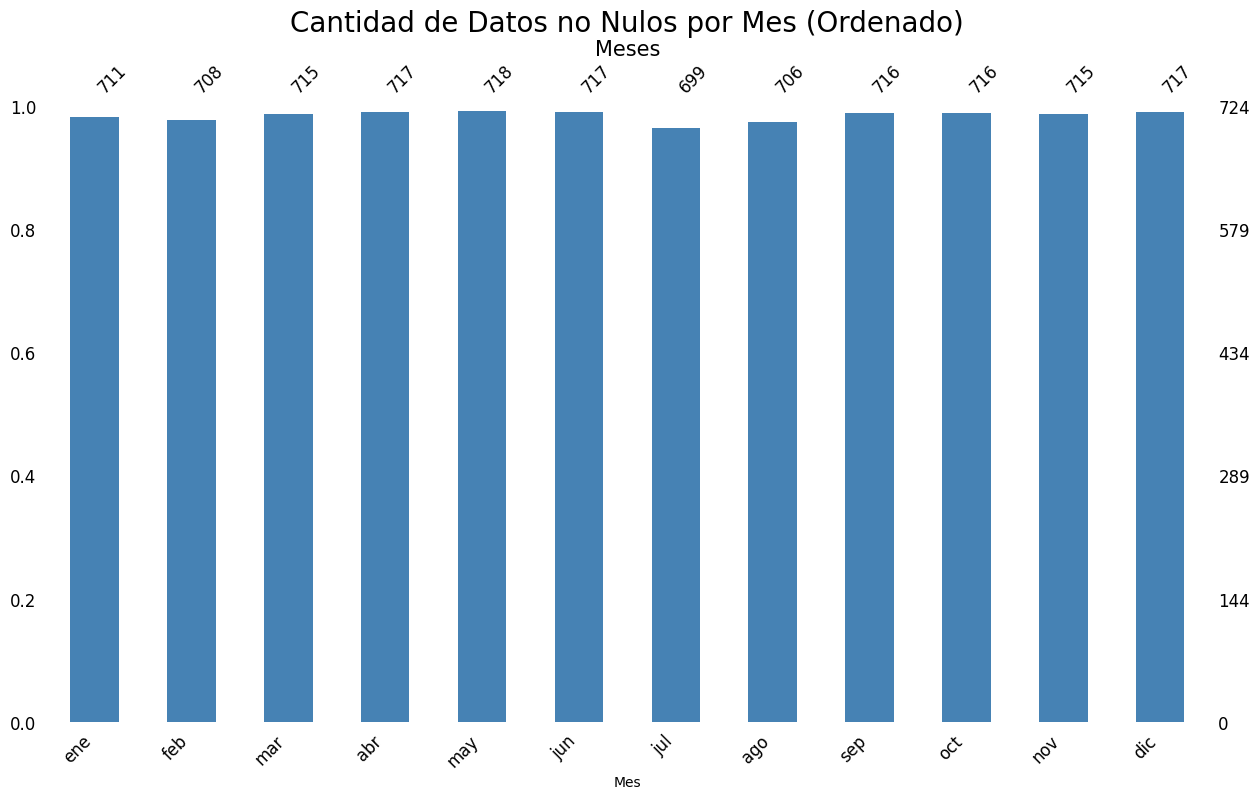

In [29]:
df_pivoted = df_enriquecido.pivot_table(
    index=['Estación', 'Variable'],
    columns='Mes',
    values='Valor'
)
msno.bar(df_pivoted, fontsize=12, figsize=(15, 8), color='steelblue')
plt.title('Cantidad de Datos no Nulos por Mes (Ordenado)', fontsize=20)
plt.xlabel('Meses', fontsize=15)
plt.ylabel('Observaciones no nulas', fontsize=15)
plt.show()


<Axes: >

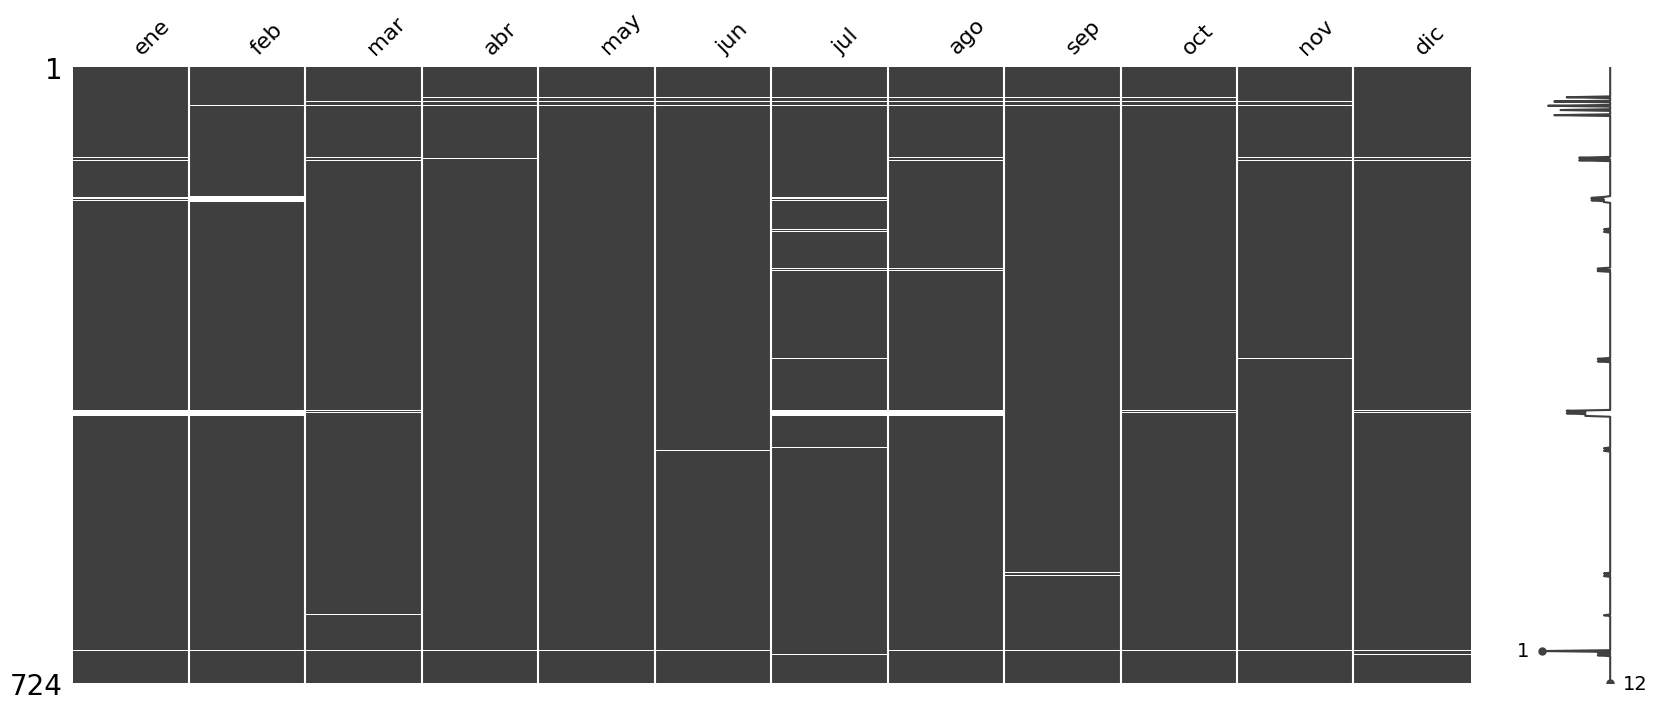

In [30]:
msno.matrix(df_pivoted, figsize=(20,8))

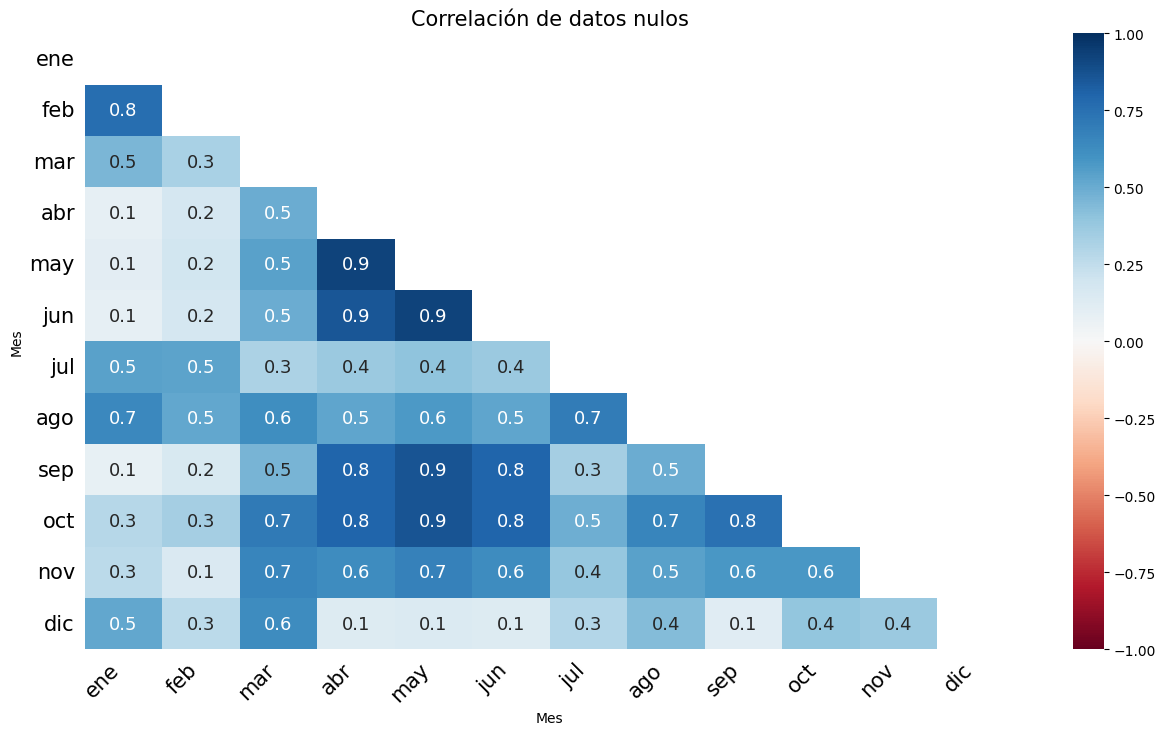

In [31]:
msno.heatmap(df_pivoted, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

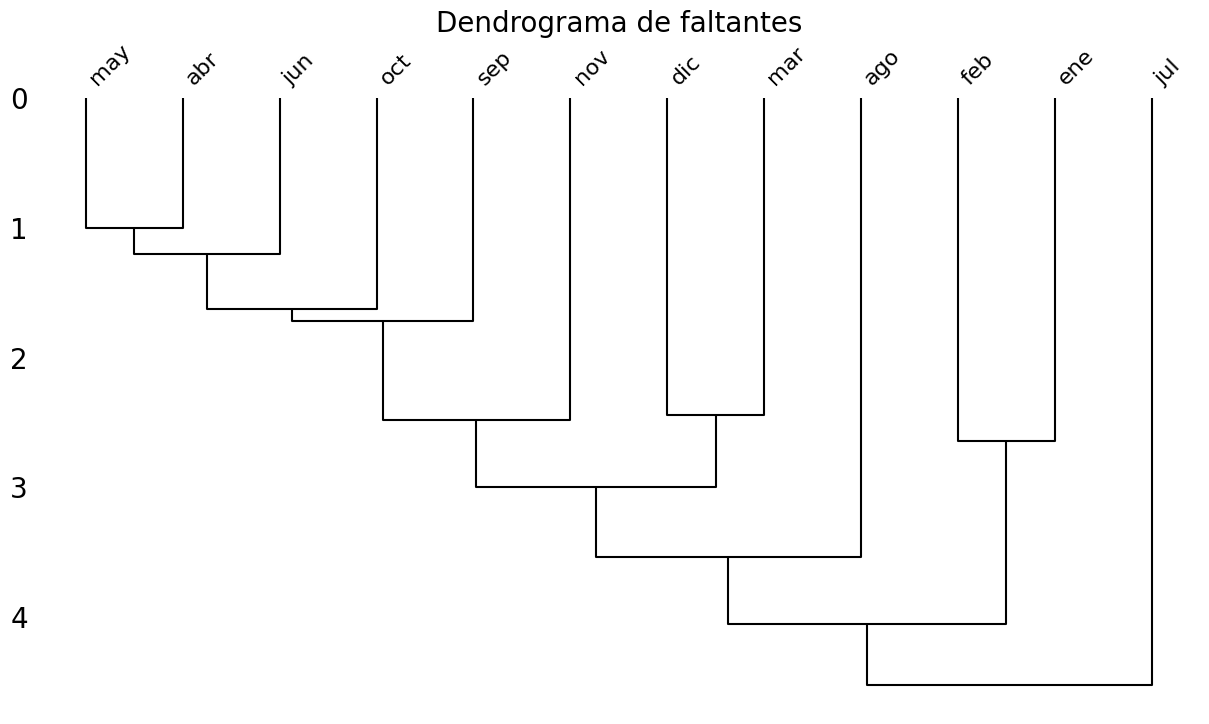

In [32]:
msno.dendrogram(df_pivoted, figsize=(15,8))
plt.title('Dendrograma de faltantes', fontsize=20)
plt.show()

***

## Tipos de Datos Faltantes

### 1. MAR (Missing at Random) - El Más Probable
* **Qué es:** La falta del dato se explica por otra variable que sí podemos observar.
* **Ejemplo en tu caso:** La **velocidad del viento** falta por completo en la estación **ORÁN AERO**, probablemente porque esa estación no tenía el equipamiento necesario. La ausencia depende de la variable `Estación`.

### 2. MNAR (Missing Not at Random) - Probable
* **Qué es:** La falta del dato es causada por el propio valor que no se pudo medir.
* **Ejemplo en tu caso:** Un termómetro que se congela y deja de reportar datos solo cuando la temperatura es extremadamente baja. La ausencia depende del valor extremo que no se registró.

### 3. MCAR (Missing Completely at Random) - El Menos Probable
* **Qué es:** La ausencia es puramente accidental y no tiene relación con ninguna variable.
* **Ejemplo en tu caso:** Un error humano al anotar un único dato al azar. Es poco probable que explique los patrones sistemáticos de tus datos.

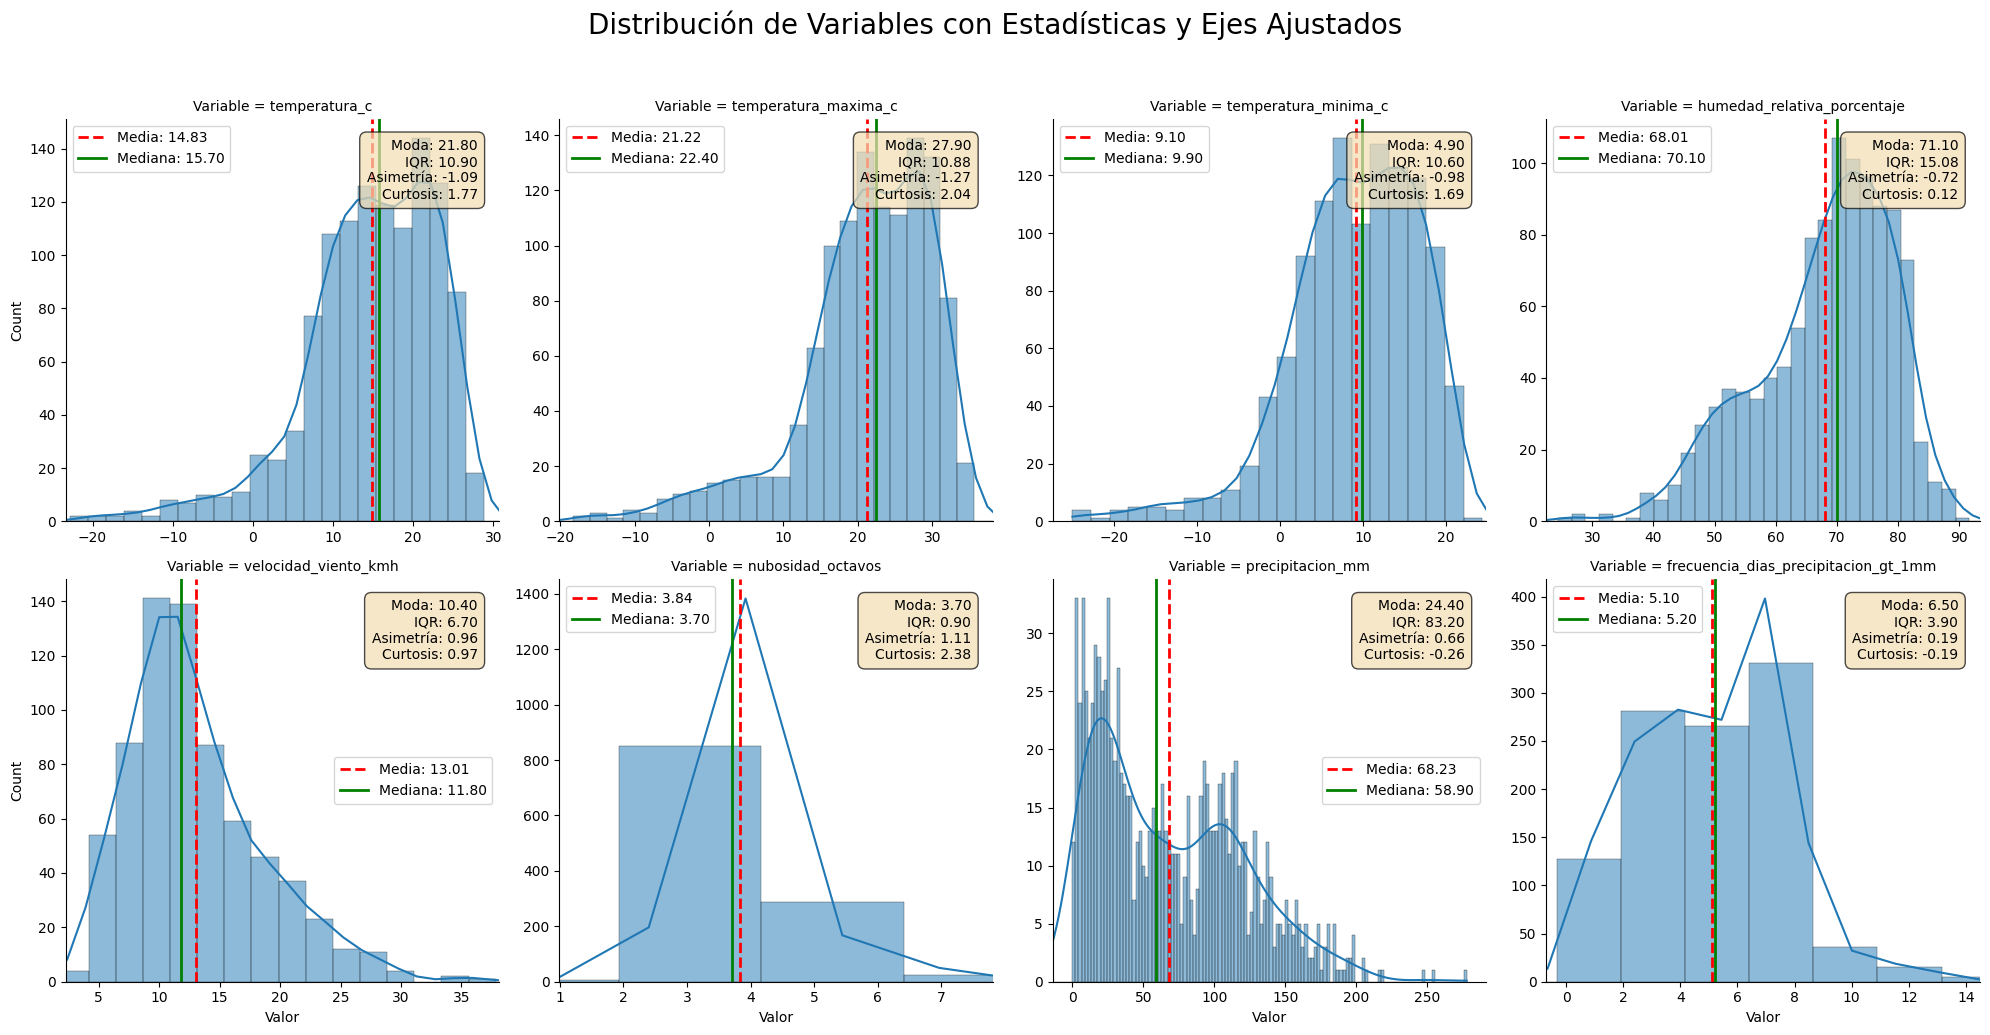

In [35]:
estadisticas_generales = df_enriquecido.groupby('Variable').agg(
    media=('Valor', 'mean'),
    mediana=('Valor', 'median'),
    moda=('Valor', mode),
    iqr=('Valor', iqr),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max') 
)

g = sns.displot(
    data=df_enriquecido,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_variable = titulo.split(' = ')[1]
    stats_variable = estadisticas_generales.loc[nombre_variable]

    if not stats_variable.empty:
        min_val = stats_variable['minimo']
        max_val = stats_variable['maximo']
        padding = (max_val - min_val) * 0.05
        ax.set_xlim(min_val - padding, max_val + padding)
        
        media = stats_variable['media']
        mediana = stats_variable['mediana']
        moda = stats_variable['moda']
        r_iqr = stats_variable['iqr']
        asim = stats_variable['asimetria_pearson']
        curt = stats_variable['curtosis_fisher']
        
        ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
        
        texto_stats = (
            f"Moda: {moda:.2f}\n"
            f"IQR: {r_iqr:.2f}\n"
            f"Asimetría: {asim:.2f}\n"
            f"Curtosis: {curt:.2f}"
        )
        
        ax.text(0.95, 0.95, texto_stats,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()

g.fig.suptitle('Distribución de Variables con Estadísticas y Ejes Ajustados', y=1.03, fontsize=20)
g.tight_layout()
plt.show()

--- Estadísticas para la provincia de: BUENOS AIRES ---
                                          media  mediana  moda    iqr  asimetria_pearson  curtosis_fisher  minimo  maximo
Variable                                                                                                                 
frecuencia_dias_precipitacion_gt_1mm   5.803540     6.00   6.0   1.90          -0.463798        -0.726220     2.7     8.6
humedad_relativa_porcentaje           74.068000    74.70  73.8   9.00          -0.587168         0.198313    52.0    86.8
nubosidad_octavos                      3.808444     3.80   3.8   0.60           0.162123        -0.631905     2.9     4.9
precipitacion_mm                      79.994248    81.95  58.7  42.80          -0.169259        -0.915043    23.8   139.4
temperatura_c                         15.265778    15.20  20.3   9.60           0.002635        -1.297459     6.1    24.6
temperatura_maxima_c                  21.508837    21.40  22.1   9.75           0.007005  

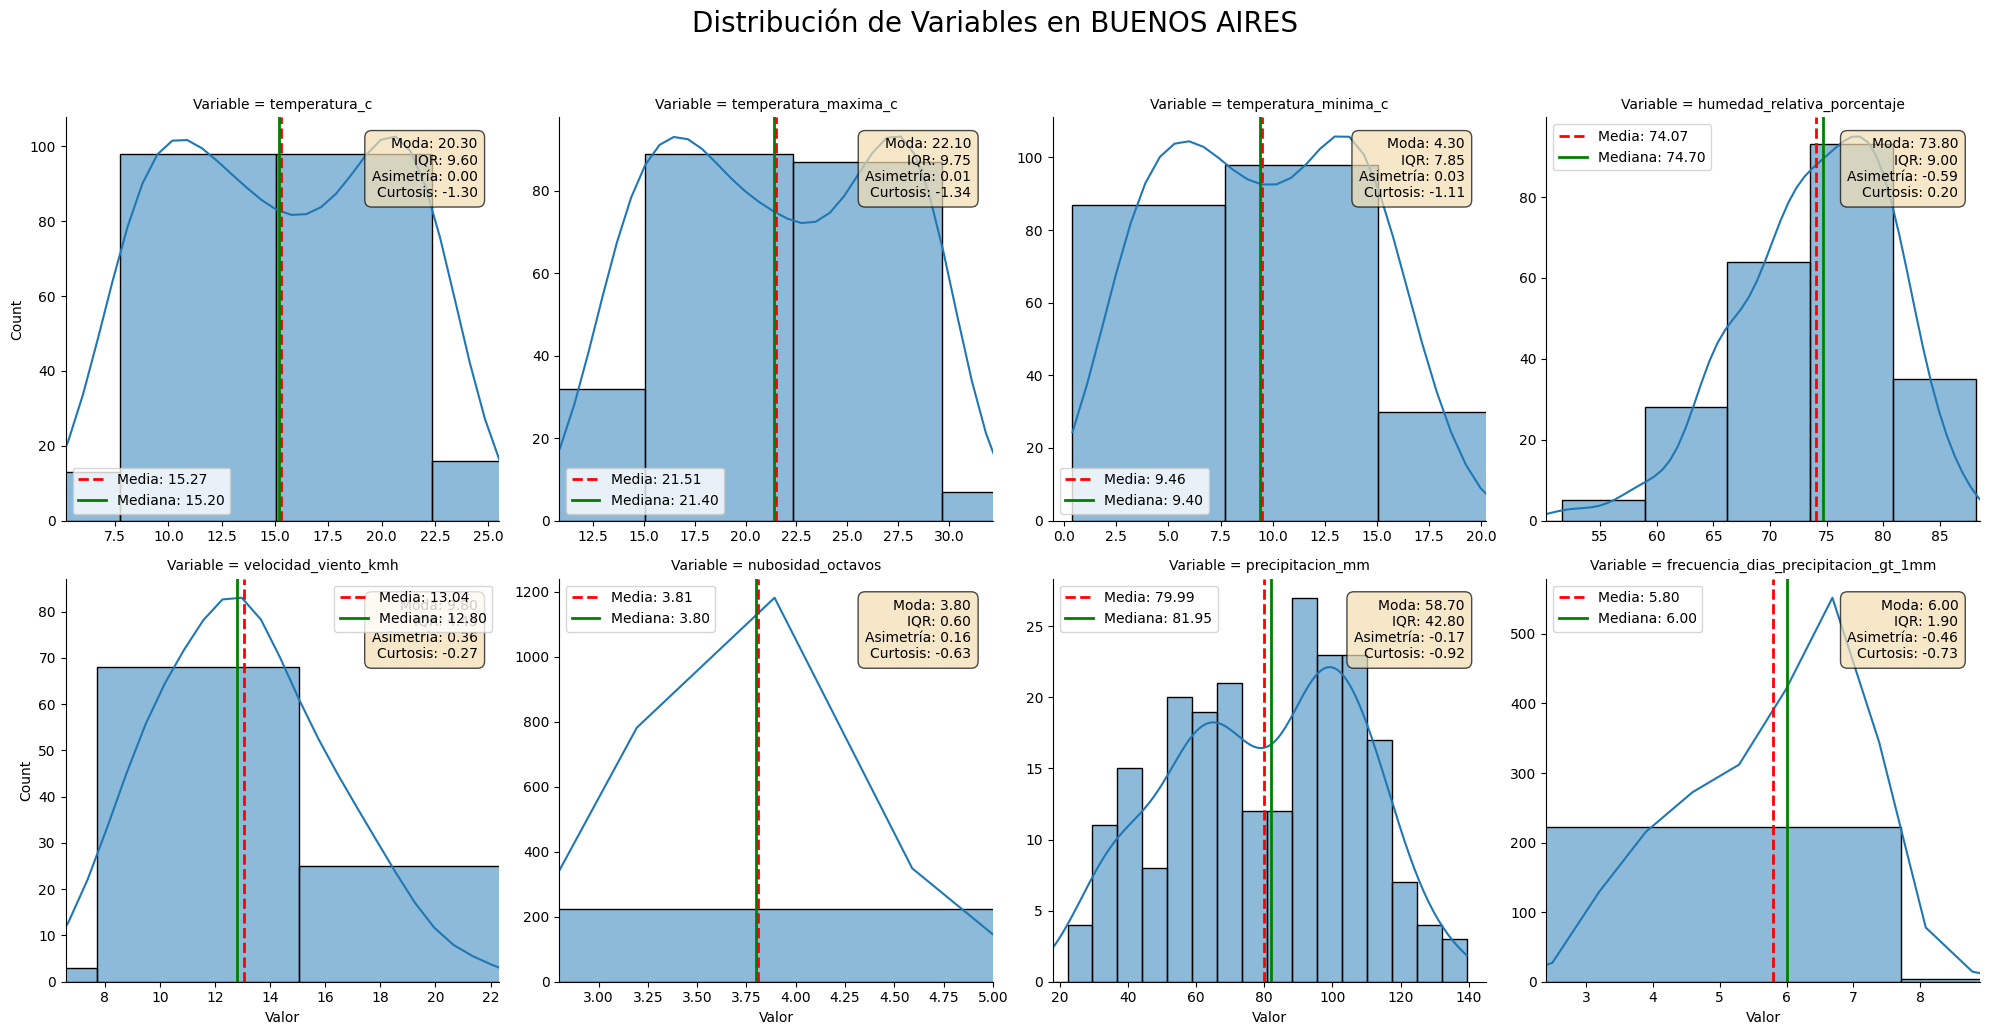

In [38]:
provincia_seleccionada = 'BUENOS AIRES'  # Cambia esto por la provincia que quieras analizar
df_provincia = df_enriquecido[df_enriquecido['provincia'] == provincia_seleccionada]

estadisticas_provincia = df_provincia.groupby('Variable').agg(
    media=('Valor', 'mean'),
    mediana=('Valor', 'median'),
    moda=('Valor', mode),
    iqr=('Valor', iqr),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max')
)

print(f"--- Estadísticas para la provincia de: {provincia_seleccionada} ---")
print(estadisticas_provincia)


g = sns.displot(
    data=df_provincia,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_variable = titulo.split(' = ')[1]

    stats_variable = estadisticas_provincia.loc[nombre_variable]

    if not stats_variable.empty:
        min_val = stats_variable['minimo']
        max_val = stats_variable['maximo']
        padding = (max_val - min_val) * 0.05
        if padding == 0: padding = 1 
        ax.set_xlim(min_val - padding, max_val + padding)
        
        media = stats_variable['media']
        mediana = stats_variable['mediana']
        moda = stats_variable['moda']
        r_iqr = stats_variable['iqr']
        asim = stats_variable['asimetria_pearson']
        curt = stats_variable['curtosis_fisher']
        
        ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
        
        texto_stats = (
            f"Moda: {moda:.2f}\n"
            f"IQR: {r_iqr:.2f}\n"
            f"Asimetría: {asim:.2f}\n"
            f"Curtosis: {curt:.2f}"
        )
        
        ax.text(0.95, 0.95, texto_stats,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()

g.fig.suptitle(f'Distribución de Variables en {provincia_seleccionada}', y=1.03, fontsize=20)
g.tight_layout()
plt.show()


--- Rangos de Temperatura por Región ---
            min   max
region               
Antártida -20.9   2.2
Cuyo        3.8  25.9
NEA        13.1  28.3
NOA         4.5  27.8
Pampeana    8.1  25.4
Patagonia   1.7  24.1


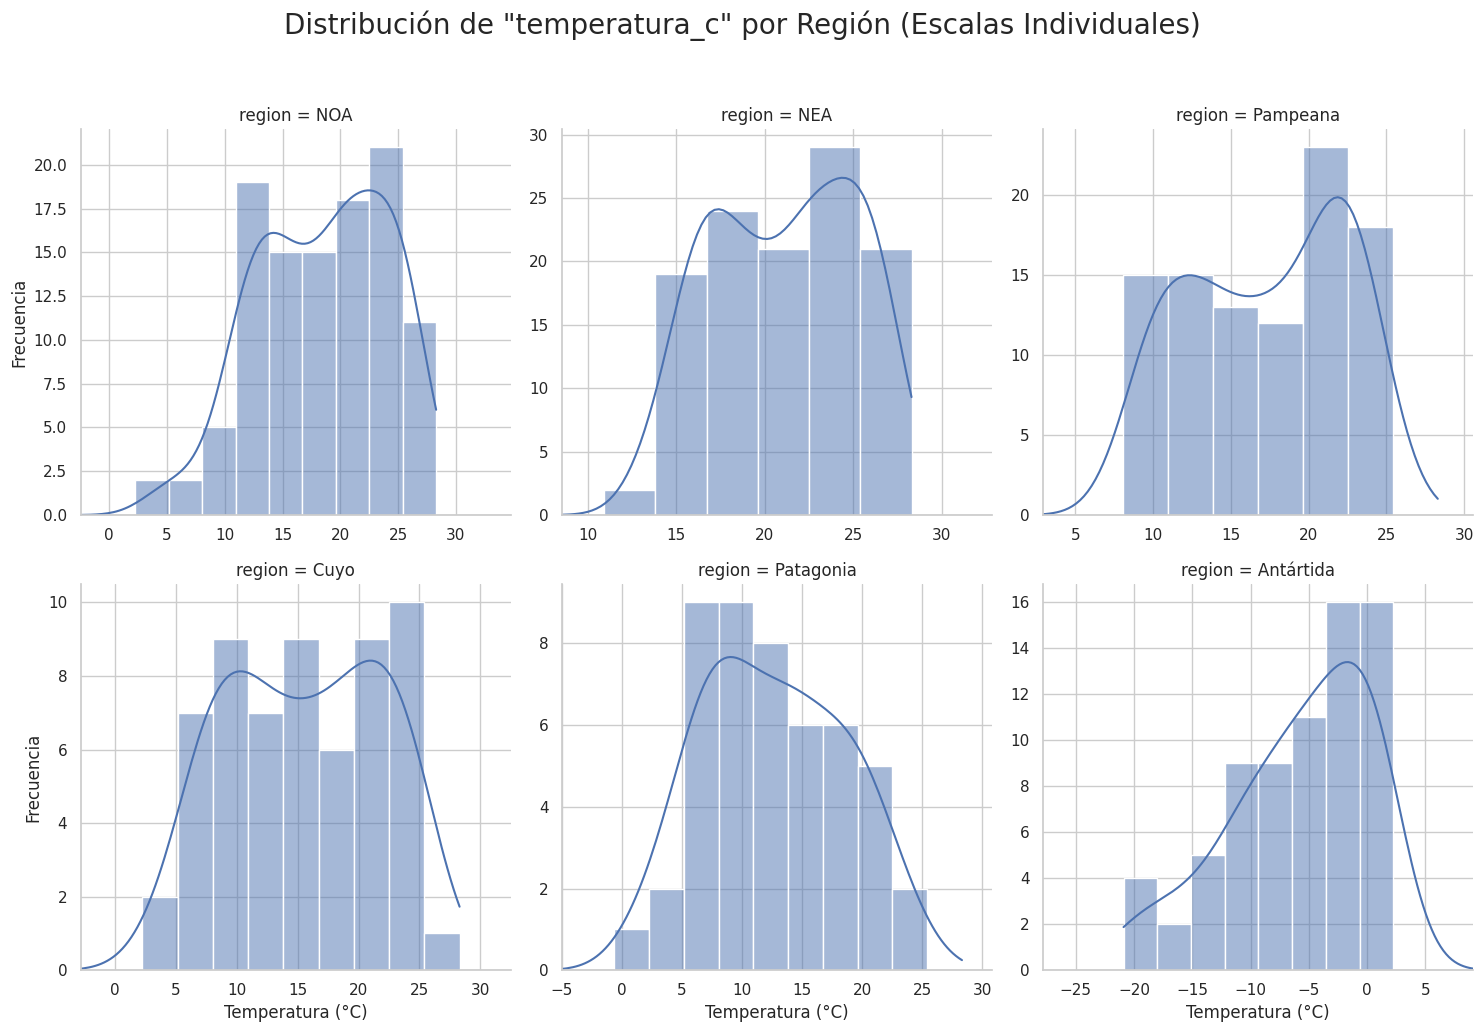

In [15]:
# Se asume que tu DataFrame 'df_enriquecido' con la columna 'region' ya existe.

# 1. Filtrar para una sola variable de interés
variable_a_analizar = 'temperatura_c'
df_filtrado_region = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (mínimo y máximo) para cada región
rangos_por_region = df_filtrado_region.groupby('region')['Valor'].agg(['min', 'max'])
print("--- Rangos de Temperatura por Región ---")
print(rangos_por_region)

# 3. Crear el gráfico de distribución con ejes independientes
g = sns.displot(
    data=df_filtrado_region,
    x='Valor',
    col='region',
    col_wrap=3,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala dinámicamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    # Extraemos el nombre de la región del título (ej: "region = NOA")
    nombre_region = titulo.split(' = ')[1]

    if nombre_region in rangos_por_region.index:
        min_val = rangos_por_region.loc[nombre_region, 'min']
        max_val = rangos_por_region.loc[nombre_region, 'max']
        
        # Añadimos un relleno (padding) del 5% del rango total para que el gráfico respire
        padding = (max_val - min_val) * 0.3
        
        # Aplicamos los límites específicos de la región
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar títulos y mostrar
g.fig.suptitle(f'Distribución de "{variable_a_analizar}" por Región (Escalas Individuales)', y=1.03, fontsize=20)
g.set_axis_labels("Temperatura (°C)", "Frecuencia")
g.fig.tight_layout()
plt.show()

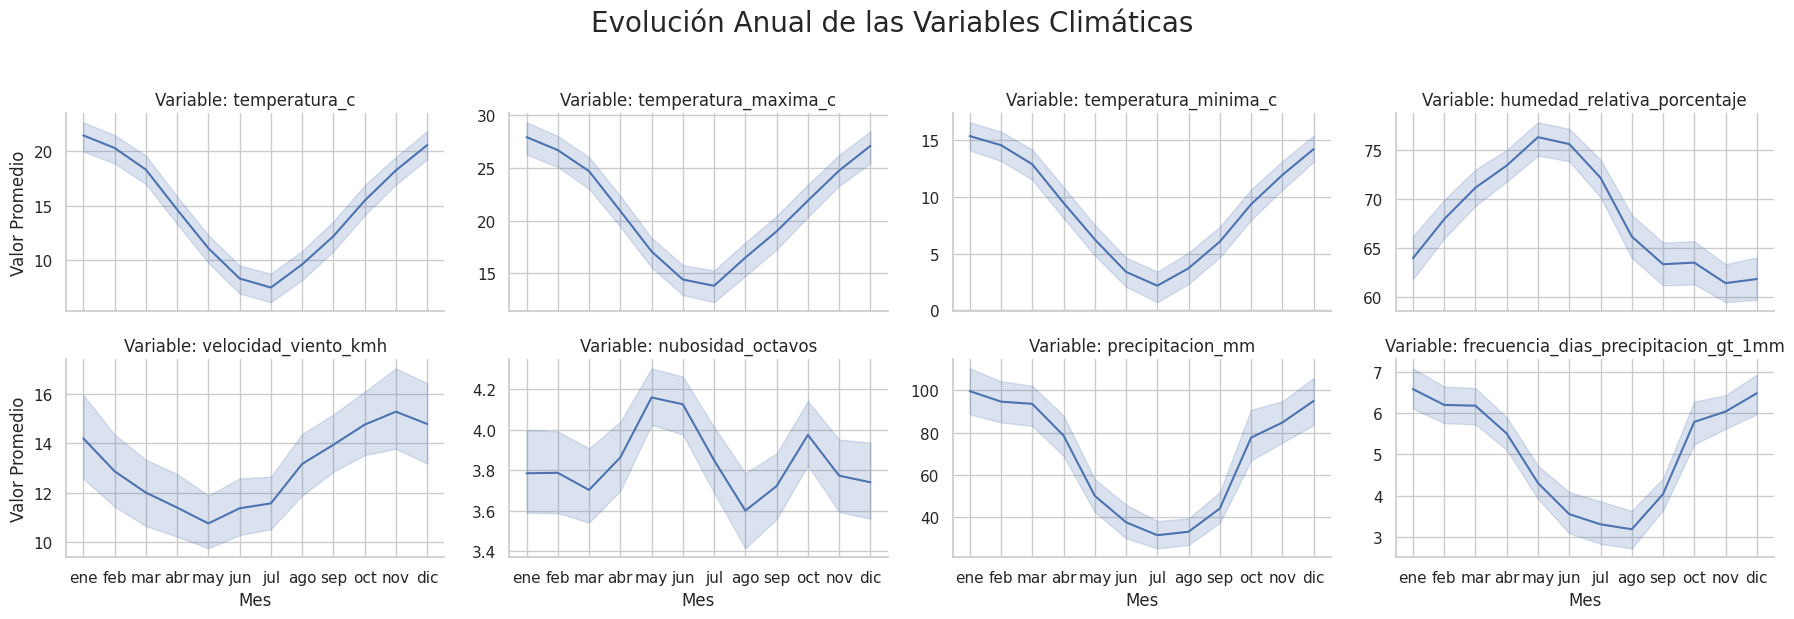

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.relplot(
    data=df_enriquecido,
    x='Mes',
    y='Valor',
    col='Variable',
    kind='line',
    col_wrap=4,
    height=3,
    aspect=1.5,
    facet_kws={'sharey': False, 'sharex': True}
)

# Ajustamos los títulos y el layout
g.fig.suptitle('Evolución Anual de las Variables Climáticas', y=1.03, fontsize=20)
g.set_titles("Variable: {col_name}")
g.set_axis_labels("Mes", "Valor Promedio")
plt.tight_layout()
plt.show()

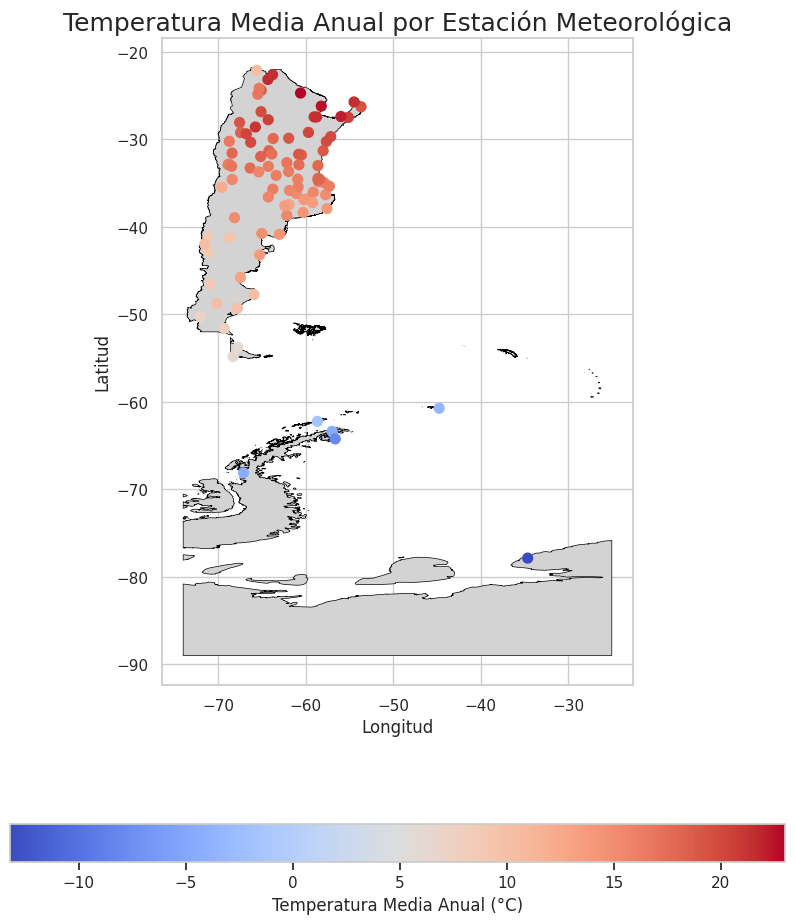

In [ ]:

gdf_estaciones = geopandas.GeoDataFrame(
    df_bases, 
    geometry=geopandas.points_from_xy(df_bases.longitud, df_bases.latitud),
    crs="EPSG:4326"
)

# --- 2. Preparar los Datos a Visualizar ---
df_temperatura_media = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('Estación')['Valor'].mean().reset_index()
df_temperatura_media.rename(columns={'Valor': 'temp_media_anual'}, inplace=True)
# --- 3. Unir Datos  ---
gdf_final_para_mapa = pd.merge(
    gdf_estaciones,
    df_temperatura_media,
    on='Estación',
    how='inner'
)

# --- 4. Dibujar el Mapa ---
ruta_al_mapa = "datos/pais/paisPolygon.shp"  # <-- CAMBIÁ ESTA RUTA
argentina_mapa = geopandas.read_file(ruta_al_mapa)


# Creamos la figura y el eje del gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Dibujamos el mapa de provincias como base
argentina_mapa.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Superponemos los puntos de las estaciones
gdf_final_para_mapa.plot(
    column='temp_media_anual', 
    ax=ax, 
    legend=True,
    cmap='coolwarm',
    markersize=50,
    legend_kwds={'label': "Temperatura Media Anual (°C)", 'orientation': "horizontal"}
)

# Configuramos el título y los ejes
ax.set_title('Temperatura Media Anual por Estación Meteorológica', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

Columnas disponibles en el mapa final: Index(['gid', 'entidad', 'fna', 'gna', 'nam', 'in1', 'fdc', 'sag', 'geometry', 'provincia_limpia', 'provincia', 'temp_media_provincial'], dtype='object')


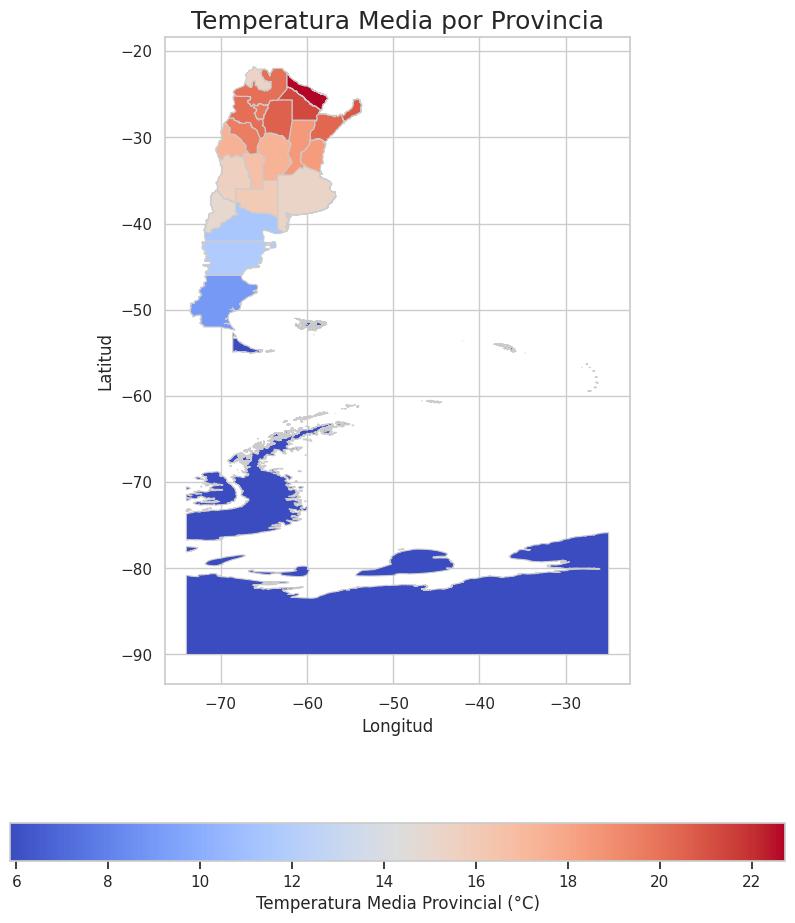

In [ ]:
# a) Calcular la temperatura media por provincia
df_temp_provincia = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('provincia')['Valor'].mean().reset_index()

# b) Renombrar la columna 'Valor' a su nombre final
df_temp_provincia.rename(columns={'Valor': 'temp_media_provincial'}, inplace=True)

# c) Limpiar los nombres de las provincias para la unión
df_temp_provincia['provincia_limpia'] = df_temp_provincia['provincia'].apply(limpiar_texto)

mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_temp_provincia['provincia_limpia'] = df_temp_provincia['provincia_limpia'].replace(mapa_correcciones)


# --- 2. PREPARAR DATOS DEL MAPA ---

ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)


mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)


# --- 3. UNIR LOS DATAFRAMES ---

mapa_final = pd.merge(
    mapa_provincias,
    df_temp_provincia,
    on='provincia_limpia',
    how='left'
)


# --- 4. DIBUJAR EL MAPA ---

print("Columnas disponibles en el mapa final:", mapa_final.columns)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

mapa_final.plot(
    column='temp_media_provincial',
    ax=ax,
    legend=True,
    cmap='coolwarm',
    linewidth=0.8,
    edgecolor='0.8',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Sin datos",
    },
    legend_kwds={'label': "Temperatura Media Provincial (°C)", 'orientation': "horizontal"}
)

ax.set_title('Temperatura Media por Provincia', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

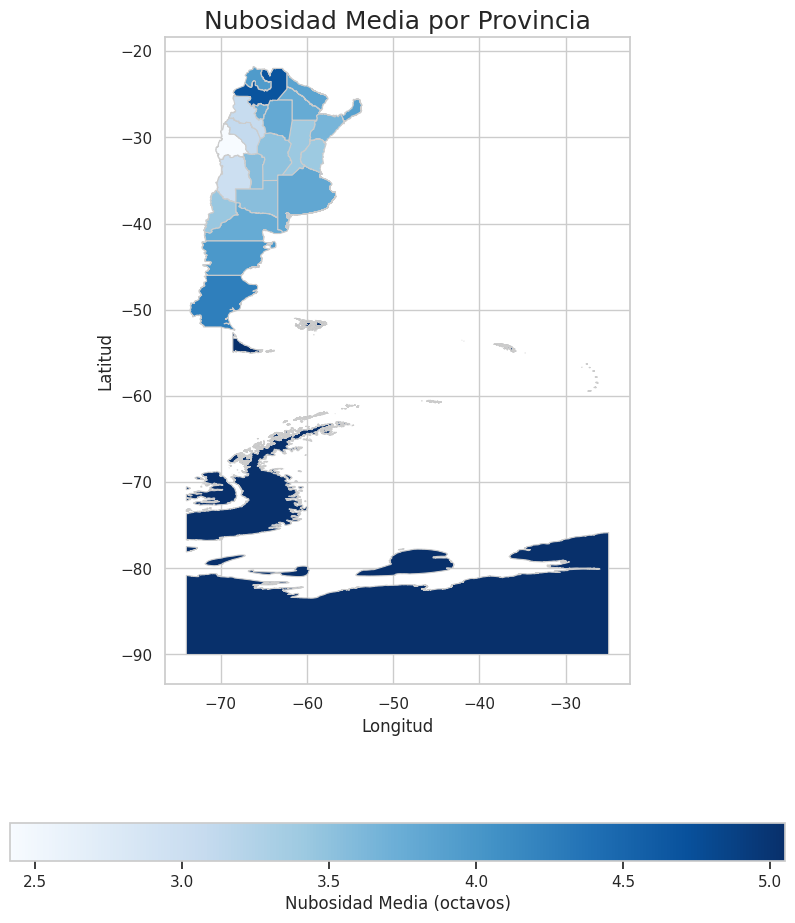

In [ ]:
# --- 1. PREPARAR DATOS DE NUBOSIDAD ---

df_nubo_provincia = df_enriquecido[df_enriquecido['Variable'] == 'nubosidad_octavos'].groupby('provincia')['Valor'].mean().reset_index()
df_nubo_provincia.rename(columns={'Valor': 'nubo_media_provincial'}, inplace=True)

df_nubo_provincia['provincia_limpia'] = df_nubo_provincia['provincia'].apply(limpiar_texto)
mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_nubo_provincia['provincia_limpia'] = df_nubo_provincia['provincia_limpia'].replace(mapa_correcciones)


# --- 2. PREPARAR DATOS DEL MAPA  ---

ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)
mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)


# --- 3. UNIR LOS DATAFRAMES ---

mapa_final_nubo = pd.merge(
    mapa_provincias,
    df_nubo_provincia,
    on='provincia_limpia',
    how='left'
)


# --- 4. DIBUJAR EL MAPA DE NUBOSIDAD ---

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

mapa_final_nubo.plot(
    column='nubo_media_provincial',
    ax=ax,
    legend=True,
    cmap='Blues', 
    linewidth=0.8,
    edgecolor='0.8',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Sin datos",
    },
    legend_kwds={'label': "Nubosidad Media (octavos)", 'orientation': "horizontal"}
)

ax.set_title('Nubosidad Media por Provincia', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

In [ ]:
#--- 1. Estadísticas Generales por Variable ---
print("--- 1. Estadísticas Generales por Variable ---")
estadisticas_generales = df_enriquecido.groupby('Variable').agg(
    conteo=('Valor', 'count'),
    media=('Valor', 'mean'),
    desvio_est=('Valor', 'std'),
    varianza=('Valor', 'var'),
    mediana=('Valor', 'median'),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max'),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt)
)
print(estadisticas_generales)

print("\n--- Moda por Variable ---")
moda_general = df_enriquecido.groupby('Variable')['Valor'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
print(moda_general)


# --- 2. Estadísticas por Región y Variable ---
print("\n" + "="*80)
print("--- 2. Estadísticas por Región y Variable ---")
estadisticas_por_region = df_enriquecido.groupby(['region', 'Variable']).agg(
    conteo=('Valor', 'count'),
    media=('Valor', 'mean'),
    desvio_est=('Valor', 'std'),
    varianza=('Valor', 'var'),
    mediana=('Valor', 'median'),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max'),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt)
)
print(estadisticas_por_region)

--- 1. Estadísticas Generales por Variable ---
                                      conteo      media  desvio_est     varianza  mediana  minimo  maximo  asimetria_pearson  curtosis_fisher
Variable                                                                                                                                     
frecuencia_dias_precipitacion_gt_1mm    1061   5.097455    2.536586     6.434267      5.2     0.0    13.8           0.185539        -0.186138
humedad_relativa_porcentaje             1110  68.005405   11.027475   121.605201     70.1    25.7    90.2          -0.719815         0.118628
nubosidad_octavos                       1166   3.840137    0.888284     0.789049      3.7     1.3     7.5           1.109340         2.384159
precipitacion_mm                        1061  68.234873   51.674519  2670.255915     58.9     0.0   277.9           0.663766        -0.262990
temperatura_c                           1167  14.834190    8.178787    66.892561     15.7   -20.9    

Outlaiers

/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


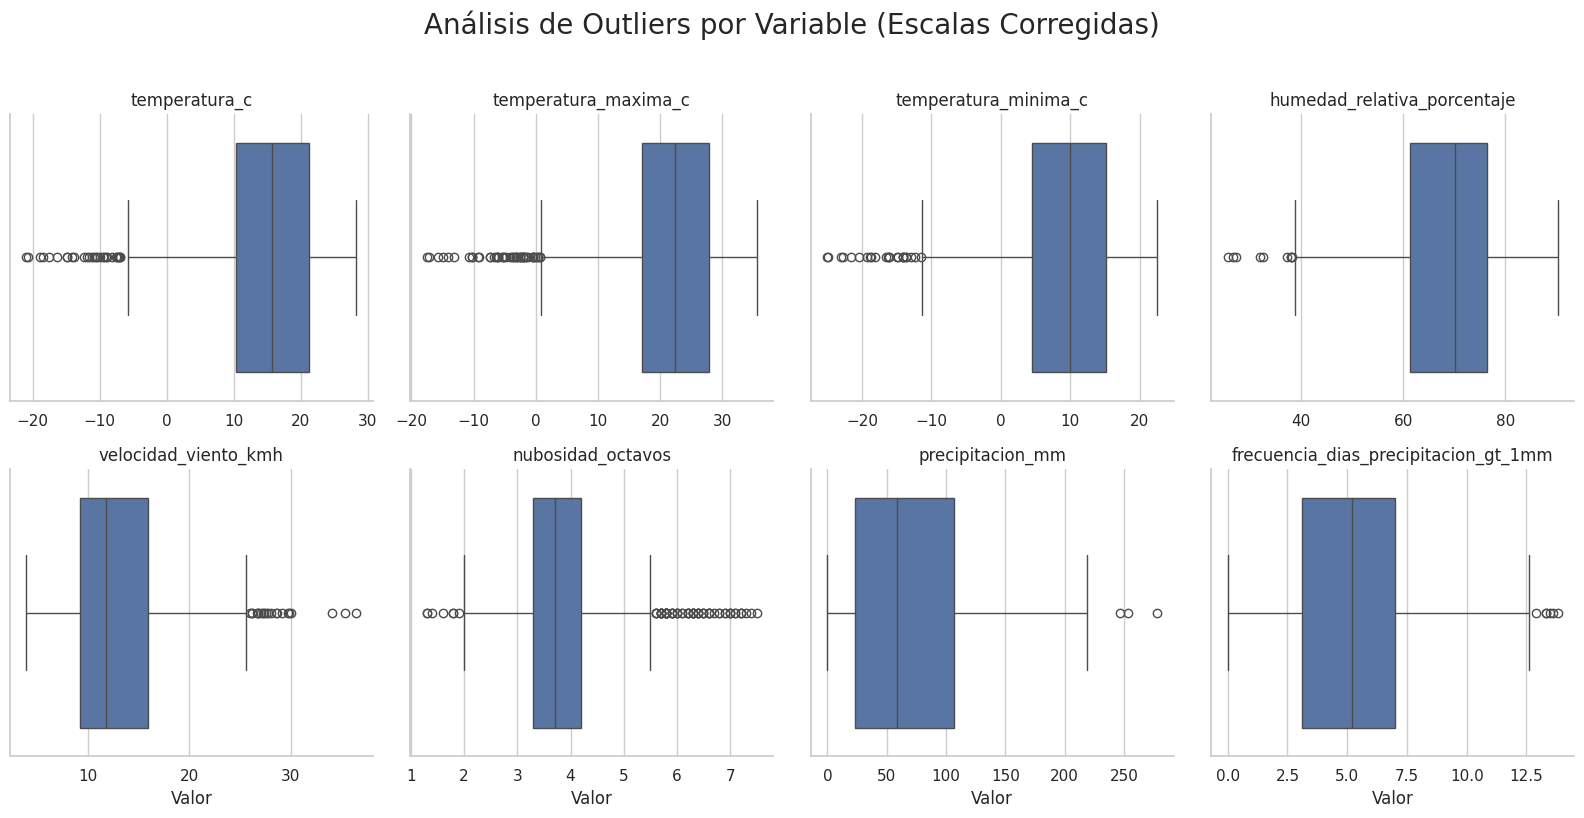

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    df_enriquecido, 
    col="Variable", 
    col_wrap=4, 
    sharey=False, 
    sharex=False, 
    height=4
)

g.map(sns.boxplot, "Valor")

g.set_axis_labels("Valor", "")
g.set_titles("{col_name}")
g.fig.suptitle("Análisis de Outliers por Variable (Escalas Corregidas)", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
Q1 = df_enriquecido.groupby('Variable')['Valor'].quantile(0.25)
Q3 = df_enriquecido.groupby('Variable')['Valor'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

limites = pd.DataFrame({'lim_inf': limite_inferior, 'lim_sup': limite_superior})
print("--- Límites para detección de outliers por Variable ---")
print(limites)

df_con_limites = pd.merge(df_enriquecido, limites, on='Variable', how='left')

outliers_generales = df_con_limites[
    (df_con_limites['Valor'] < df_con_limites['lim_inf']) | 
    (df_con_limites['Valor'] > df_con_limites['lim_sup'])
]

conteo_de_outliers = outliers_generales['Variable'].value_counts()

total_por_variable = df_enriquecido['Variable'].value_counts()

resumen_outliers = pd.DataFrame({
    'total_registros': total_por_variable,
    'cantidad_outliers': conteo_de_outliers
}).fillna(0)

resumen_outliers['porcentaje_outliers'] = (resumen_outliers['cantidad_outliers'] / resumen_outliers['total_registros']) * 100

print("\n--- Resumen Porcentual de Outliers por Variable ---")
print(resumen_outliers)

--- Límites para detección de outliers por Variable ---
                                       lim_inf   lim_sup
Variable                                                
frecuencia_dias_precipitacion_gt_1mm   -2.7500   12.8500
humedad_relativa_porcentaje            38.7125   99.0125
nubosidad_octavos                       1.9500    5.5500
precipitacion_mm                     -101.5000  231.3000
temperatura_c                          -6.0500   37.5500
temperatura_maxima_c                    0.7125   44.2125
temperatura_minima_c                  -11.4000   31.0000
velocidad_viento_kmh                   -0.8500   25.9500

--- Resumen Porcentual de Outliers por Variable ---
                                      total_registros  cantidad_outliers  porcentaje_outliers
Variable                                                                                     
frecuencia_dias_precipitacion_gt_1mm             1176                  6             0.510204
humedad_relativa_porcentaje            

/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:854: Future

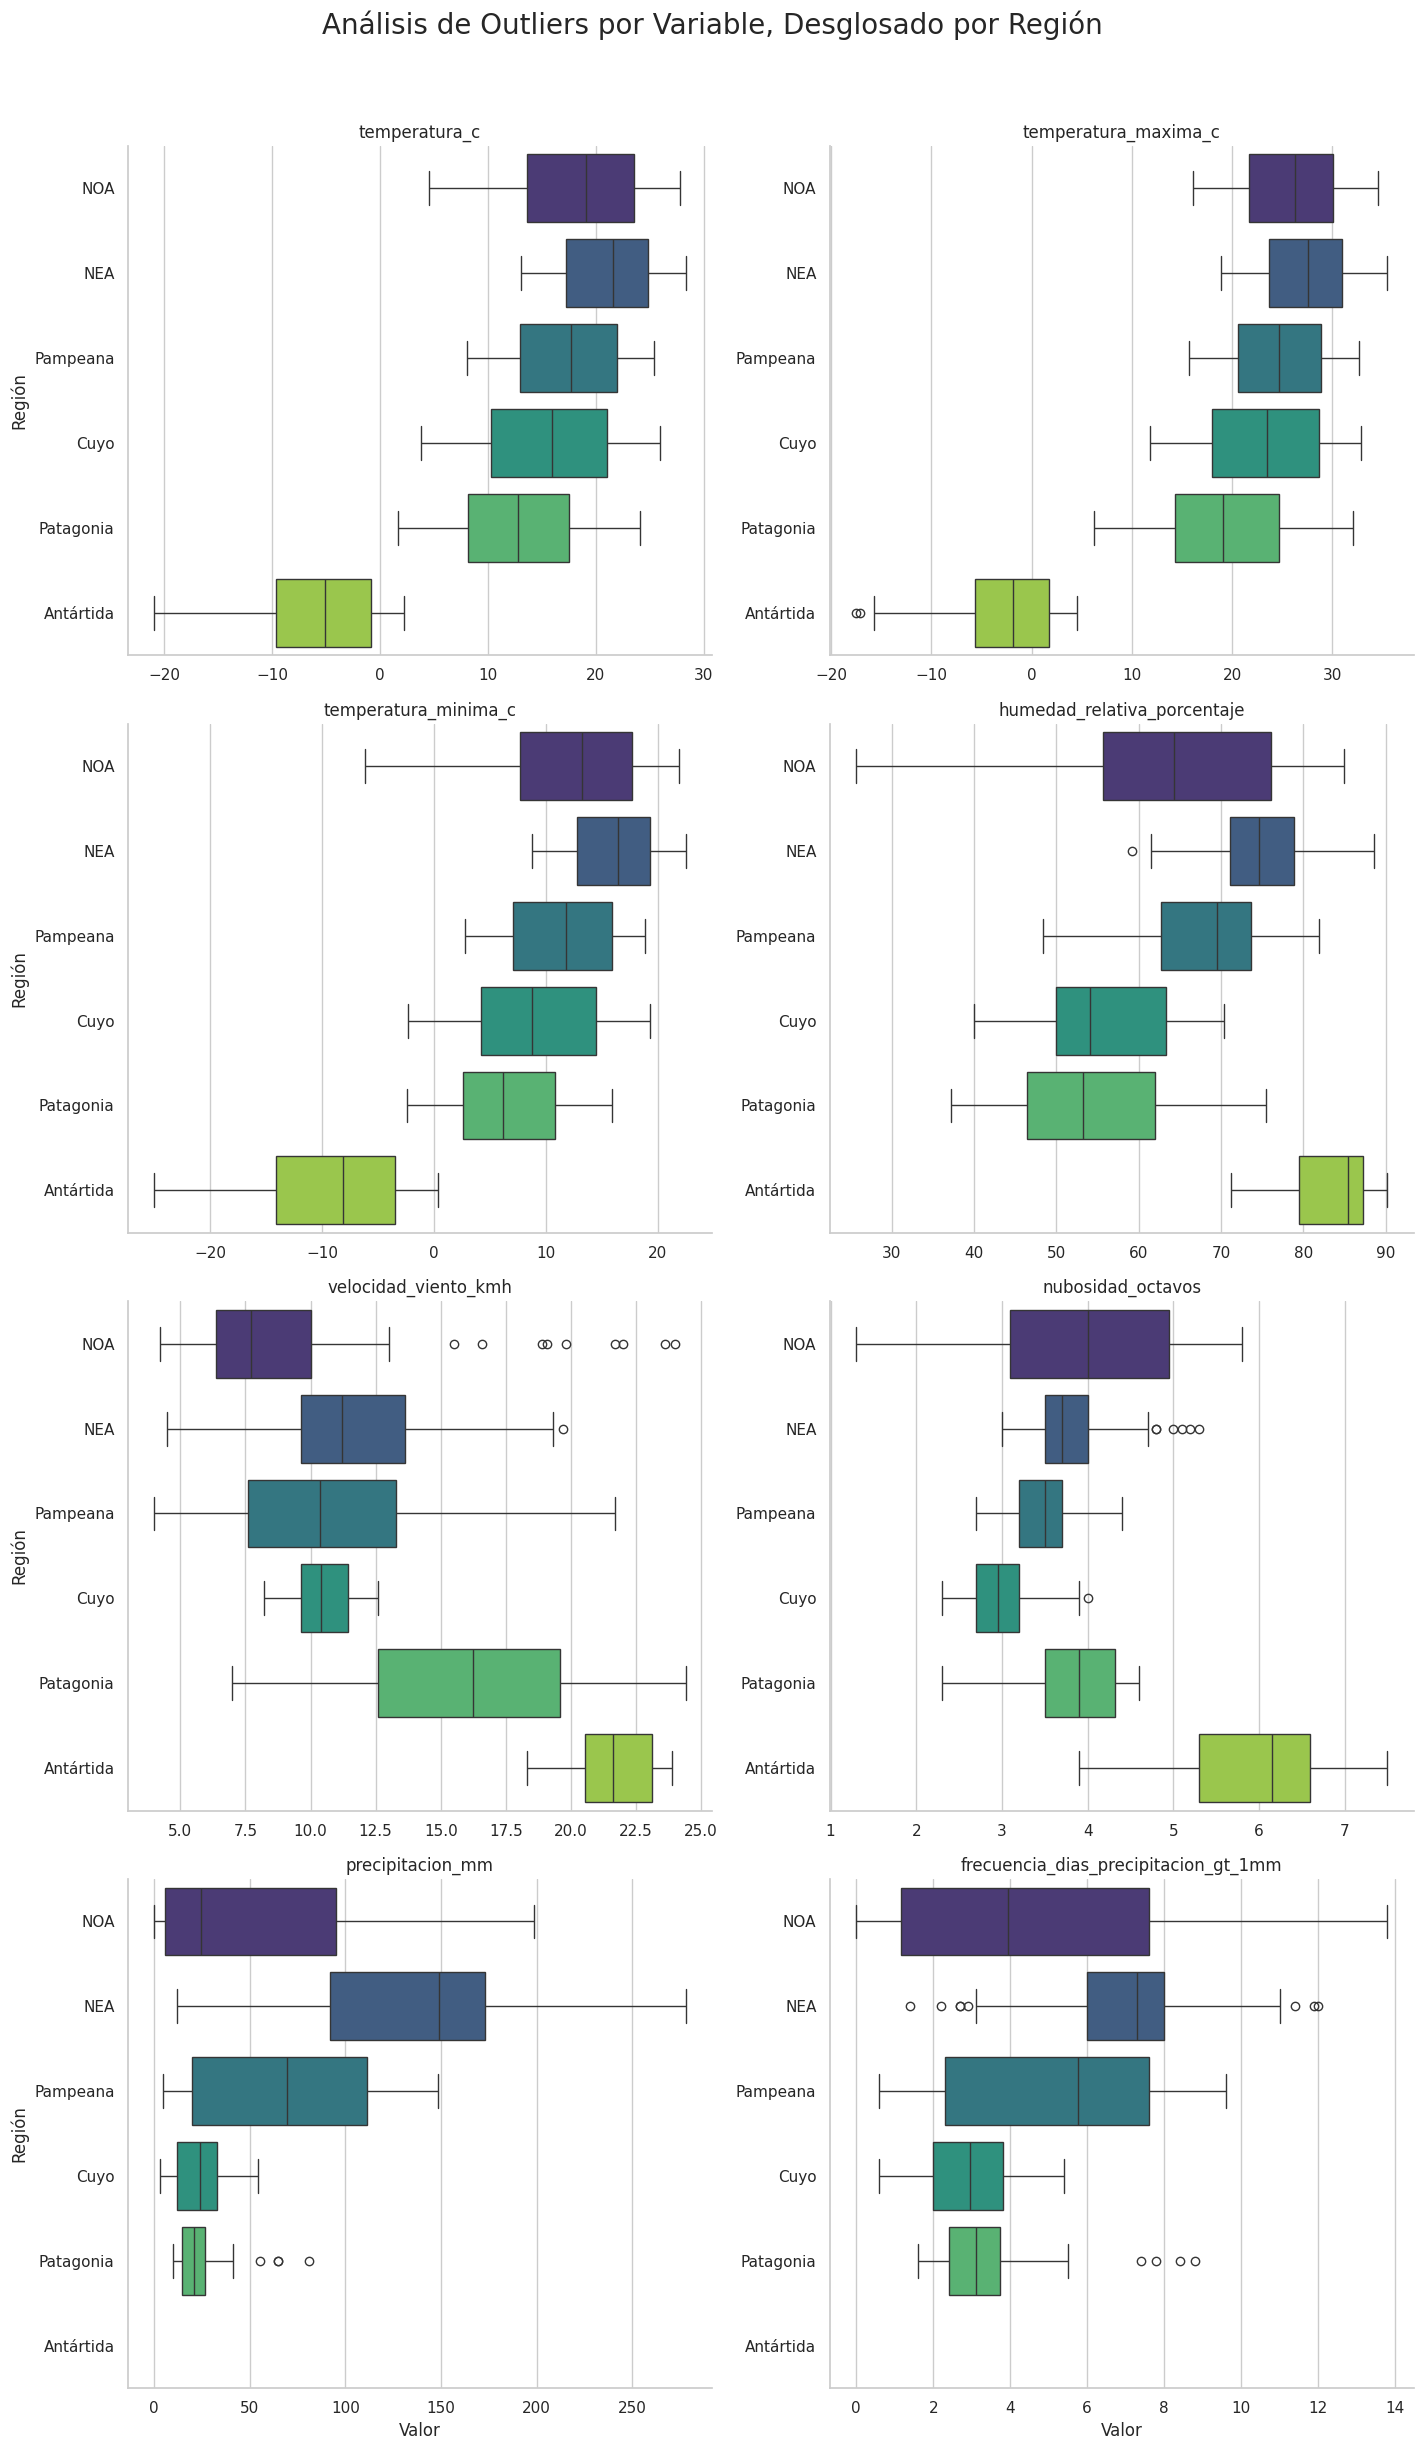

In [44]:
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    df_enriquecido, 
    col="Variable", 
    col_wrap=2,  
    sharex=False, 
    sharey=False, 
    height=6,   
    aspect=1.2
)


g.map(sns.boxplot, 'Valor', 'region', palette='viridis')
g.set_axis_labels("Valor", "Región")
g.set_titles("{col_name}")
g.fig.suptitle("Análisis de Outliers por Variable, Desglosado por Región", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [40]:
# Calculamos los límites agrupando por región Y variable
Q1_region = df_enriquecido.groupby(['region', 'Variable'])['Valor'].quantile(0.25)
Q3_region = df_enriquecido.groupby(['region', 'Variable'])['Valor'].quantile(0.75)
IQR_region = Q3_region - Q1_region

# Calculamos los límites inferior y superior
lim_inf_region = Q1_region - 1.5 * IQR_region
lim_sup_region = Q3_region + 1.5 * IQR_region 

# Creamos un DataFrame con los límites
limites_region = pd.DataFrame({'lim_inf': lim_inf_region, 'lim_sup': lim_sup_region}).reset_index()
limites_region.head()
# Unimos los límites al DataFrame original
df_con_limites_region = pd.merge(df_enriquecido, limites_region, on=['region', 'Variable'], how='left')

# Filtramos los outliers usando los límites corregidos
outliers_region = df_con_limites_region[
    (df_con_limites_region['Valor'] < df_con_limites_region['lim_inf']) | 
    (df_con_limites_region['Valor'] > df_con_limites_region['lim_sup'])
]

conteo_outliers_region = outliers_region.groupby(['region', 'Variable']).size()
total_por_region = df_enriquecido.groupby(['region', 'Variable']).size()

resumen_outliers_region = pd.DataFrame({
    'total_registros': total_por_region,
    'cantidad_outliers': conteo_outliers_region
}).fillna(0)

resumen_outliers_region['porcentaje_outliers'] = \
    (resumen_outliers_region['cantidad_outliers'] / resumen_outliers_region['total_registros']) * 100

print("\n--- Resumen Porcentual de Outliers por Región ---")
print(resumen_outliers_region)


--- Resumen Porcentual de Outliers por Región ---
                                                total_registros  cantidad_outliers  porcentaje_outliers
region    Variable                                                                                     
Antártida frecuencia_dias_precipitacion_gt_1mm               72                0.0             0.000000
          humedad_relativa_porcentaje                        72                0.0             0.000000
          nubosidad_octavos                                  72                0.0             0.000000
          precipitacion_mm                                   72                0.0             0.000000
          temperatura_c                                      72                0.0             0.000000
          temperatura_maxima_c                               72                2.0             2.777778
          temperatura_minima_c                               72                0.0             0.000000
          vel